In [92]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import MLP
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import time
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn

In [93]:
# read data

dataPd = pd.read_csv('./../../data/ionosphere/ionosphere.data', sep=",", header=None)
glass = dataPd.to_numpy()

df = pd.DataFrame(glass)
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,...,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453,g
1,1,0,1.0,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.0,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.1904,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.0,-0.03365,1.0,0.00485,1.0,-0.12062,0.88965,0.01198,...,-0.4022,0.58984,-0.22145,0.431,-0.17365,0.60436,-0.2418,0.56045,-0.38238,g
3,1,0,1.0,-0.45161,1.0,1.0,0.71216,-1.0,0.0,0.0,...,0.90695,0.51613,1.0,1.0,-0.20099,0.25682,1.0,-0.32382,1.0,b
4,1,0,1.0,-0.02401,0.9414,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.1329,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,-0.04202,0.83479,0.00123,1.0,0.12815,0.8666,-0.10714,0.90546,-0.04307,g
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.0192,0.9459,0.01606,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,g
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.03193,0.92489,0.02542,0.9212,0.02242,0.92459,0.00442,0.92697,-0.00577,g
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.0011,...,-0.02099,0.89147,-0.0776,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,g


In [94]:
# create a dataset class

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.transform = transform
        self.data = data 
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int):
        data, label = self.data[index], self.labels[index]

        if self.transform is not None:
            data = self.transform(data)

        return data, label

In [95]:
# create datasets

labelDescription = ['good', 'bad']

xDf = df.iloc[:,:-1]
for col in range(34):
    xDf[col] = pd.to_numeric(xDf[col])

x = ((xDf-xDf.min())/(xDf.max()-xDf.min())).to_numpy()
x[:, 1] = 0

y = df.iloc[:,34]
y[y == 'b'] = '0'
y[y == 'g'] = '1'
y = pd.to_numeric(y).to_numpy()

# split train data into train and validation sets without changing class distribution
# 80% train, 10% validation, 10% test
data_train, data_test, labels_train, labels_test = train_test_split(x, y, test_size=0.1, stratify=y)
data_train, data_valid, labels_train, labels_valid = train_test_split(data_train, labels_train, test_size=0.1111111111, stratify=labels_train)


batch_size=32

trainDataset = CustomDataset(data_train, labels_train, transform=None)
validDataset = CustomDataset(data_valid, labels_valid, transform=None)
testDataset = CustomDataset(data_test, labels_test, transform=None)


/tmp/ipykernel_173710/3050709133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xDf[col] = pd.to_numeric(xDf[col])


In [96]:
# train

model = MLP(in_channels=34, hidden_channels=[100,100,100,100,100,100], activation_layer=nn.ReLU)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1500
epoch_print_step = 100

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_f1_history = []
val_f1_history = []
timestart = time.time()

for epoch in range(epochs):
    # index 0 is for training, index 1 for validation
    epoch_loss = [0, 0]
    accuracy = [0, 0]
    f1_score = [0, 0]
    epochtime = time.time()
    
    for dataset, isTraining in [(trainDataset, True), (validDataset, False)]:
        correct = 0
        running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []

        if isTraining:
            model.train()
        else:
            model.eval()

        if isTraining:
            # zero the parameter gradients
            optimizer.zero_grad()

        data = torch.from_numpy(dataset.data).type(torch.FloatTensor)
        labels = torch.from_numpy(dataset.labels).type(torch.LongTensor)

        # forward 
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        
        l1_lambda = 0.05
        l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
        loss = loss + l1_lambda * l1_norm

        if isTraining:
            # backward + optimize
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item() * data.size(0)
        correct += torch.sum(predicted == labels.data)
        all_predicted_labels.append(predicted)
        all_input_labels.append(labels)
        
        index = 0 if isTraining else 1
        epoch_loss[index] = running_loss / len(dataset)
        accuracy[index] = correct.double() / len(dataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score[index] = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

    if epoch % epoch_print_step == epoch_print_step-1:
        print("\r" + f'EPOCH: [{epoch + 1:2d}/{epochs}, {epoch_print_step}_time: {math.floor(time.time() - timestart)}s]   TRAIN: [loss: {epoch_loss[0]:.3f}, acc: {accuracy[0]:.3f}, f1: {f1_score[0]:.3f}]   VAL: [loss: {epoch_loss[1]:.3f}, acc: {accuracy[1]:.3f}, f1: {f1_score[1]:.3f}]') 
        timestart = time.time()
    train_loss_history.append(epoch_loss[0])
    val_loss_history.append(epoch_loss[1])
    train_acc_history.append(accuracy[0])
    val_acc_history.append(accuracy[1])
    train_f1_history.append(f1_score[0])
    val_f1_history.append(f1_score[1])

print('done')

EPOCH: [100/1500, 100_time: 1s]   TRAIN: [loss: 2.362, acc: 0.643, f1: 0.391]   VAL: [loss: 2.377, acc: 0.629, f1: 0.386]
EPOCH: [200/1500, 100_time: 1s]   TRAIN: [loss: 2.036, acc: 0.643, f1: 0.391]   VAL: [loss: 2.058, acc: 0.629, f1: 0.386]
EPOCH: [300/1500, 100_time: 1s]   TRAIN: [loss: 1.808, acc: 0.643, f1: 0.391]   VAL: [loss: 1.837, acc: 0.629, f1: 0.386]
EPOCH: [400/1500, 100_time: 1s]   TRAIN: [loss: 1.526, acc: 0.750, f1: 0.649]   VAL: [loss: 1.619, acc: 0.657, f1: 0.464]
EPOCH: [500/1500, 100_time: 1s]   TRAIN: [loss: 1.109, acc: 0.954, f1: 0.949]   VAL: [loss: 1.378, acc: 0.800, f1: 0.747]
EPOCH: [600/1500, 100_time: 1s]   TRAIN: [loss: 0.912, acc: 0.979, f1: 0.976]   VAL: [loss: 1.165, acc: 0.886, f1: 0.867]
EPOCH: [700/1500, 100_time: 1s]   TRAIN: [loss: 0.804, acc: 0.989, f1: 0.988]   VAL: [loss: 1.082, acc: 0.886, f1: 0.867]
EPOCH: [800/1500, 100_time: 1s]   TRAIN: [loss: 0.737, acc: 0.993, f1: 0.992]   VAL: [loss: 1.046, acc: 0.886, f1: 0.867]
EPOCH: [900/1500, 100_ti

[TEST] loss: 0.274, accuracy: 0.861, f1_score: 0.867
['good', 'bad']
Axes(0.125,0.11;0.62x0.77)


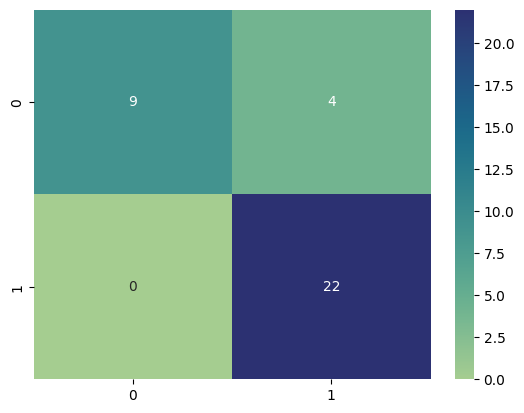

In [97]:
# test 

model.eval()

test_running_loss = 0
correct = 0
all_predicted_labels = []
all_input_labels = []

data = torch.from_numpy(dataset.data).type(torch.FloatTensor)
labels = torch.from_numpy(dataset.labels).type(torch.LongTensor)

outputs = model(data)
_, predicted = torch.max(outputs, 1)
loss = criterion(outputs, labels)

test_running_loss += loss.item() * data.size(0)
correct += torch.sum(predicted == labels.data)
all_predicted_labels.append(predicted)
all_input_labels.append(labels)

final_loss = test_running_loss / len(testDataset)
accuracy = correct.double() / len(testDataset)
all_input_labels = np.concatenate(all_input_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)
f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

print(f'[TEST] loss: {final_loss:.3f}, accuracy: {accuracy:.3f}, f1_score: {f1_score:.3f}')

# show confusion matrix
print(labelDescription)
print(sns.heatmap(confusion_matrix(all_input_labels, all_predicted_labels, labels=[i for i in range(2)]), annot=True, cmap="crest", fmt='g'))

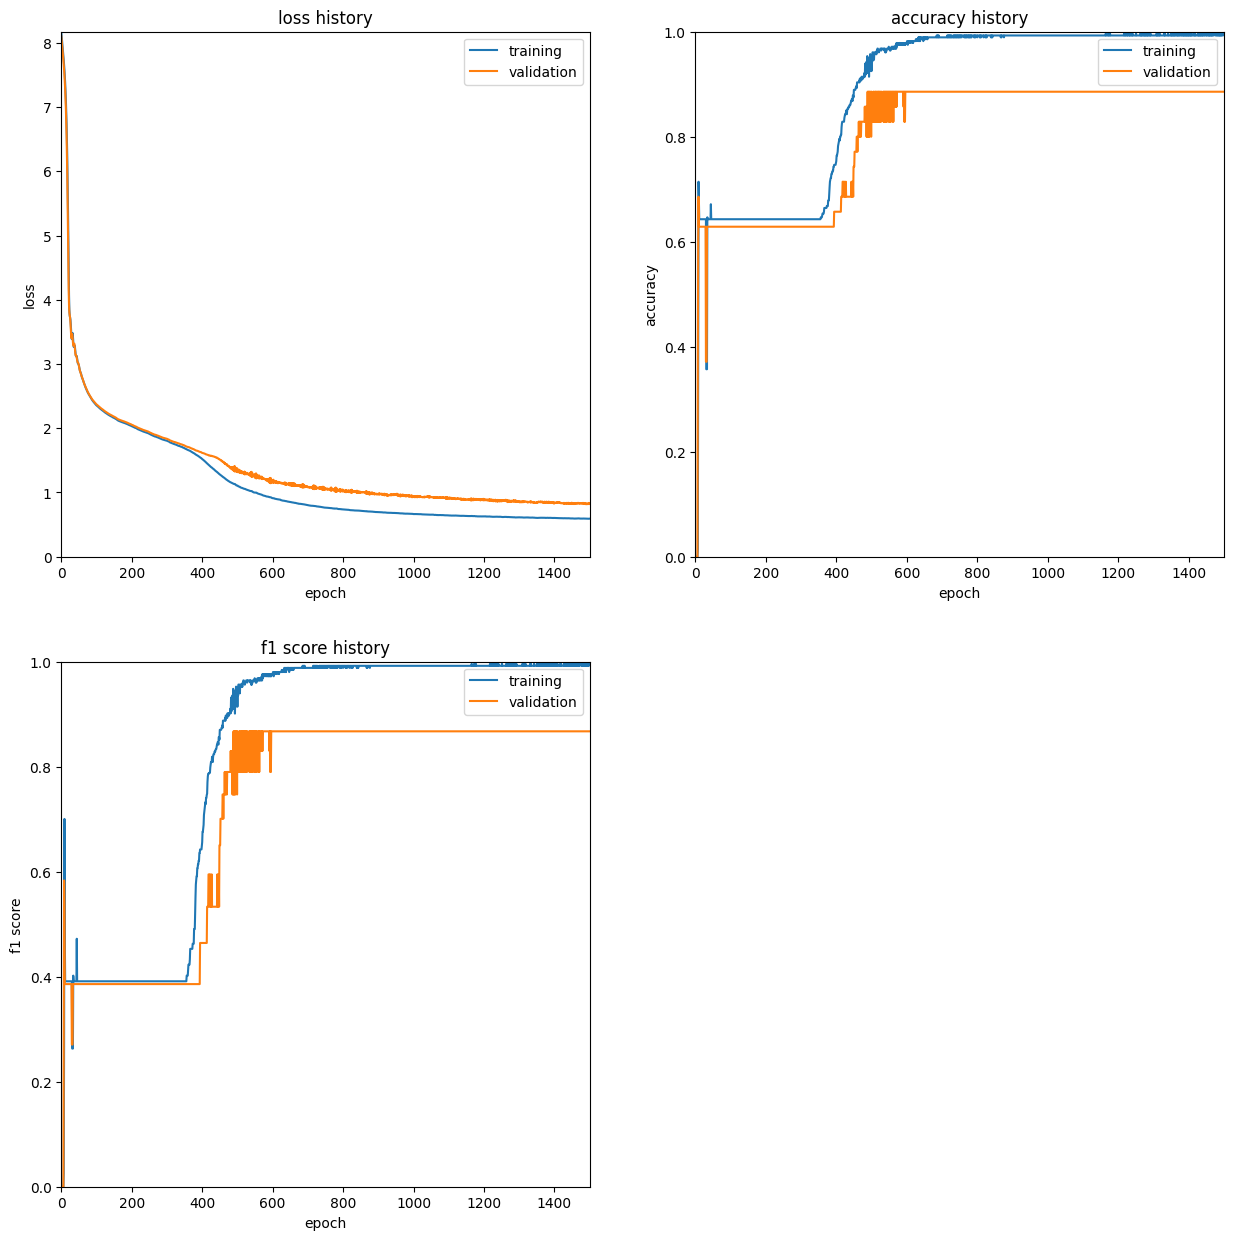

In [98]:
# plot train and validation loss

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0, len(train_loss_history))
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)))
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['training', 'validation'])

plt.subplot(2, 2, 2)
plt.title('accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(0, len(train_acc_history))
plt.ylim(0, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['training', 'validation'])

plt.subplot(2, 2, 3)
plt.title('f1 score history')
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.xlim(0, len(train_f1_history))
plt.ylim(0, 1)
plt.plot(train_f1_history)
plt.plot(val_f1_history)
plt.legend(['training', 'validation'])

plt.show()